In [1]:
import torch
from resnet import ResNetClassifier as RC
from VAE import ATTENTION_VAE
import pandas as pd
import sklearn
import glob, random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import seaborn as sn

con = {'lr': 1e-3, 'dr': 0.1, 'batch_size': 512, 'datatype': 'HCB20T', 'epochs': 10} #resnet
model = RC(con, 2, 152, optimizer='adam')

checkpoint = torch.load("./tb_logs_200epochs_cleared/resnet_trial/ResNet_200/checkpoints/epoch=199-step=26399.ckpt",map_location=torch.device('cpu')) #load VAE or resnet results
#checkpoint = torch.load("./tb_logs_200epochs_cleared/VAE_trial/VAE_200_v1/checkpoints/epoch=199-step=13799.ckpt",map_location=torch.device('cpu')) #load VAE or resnet results
model.prepare_data()  # just fetches the data
model.criterion.weight = torch.tensor([0., 0.])  # need to add as this is saved by the checkpoint file, but not the model
model.load_state_dict(checkpoint['state_dict'])  # load checkpoint file
model.eval()
import MLmodels as m
test_set = m.test_set_corr
dca_set = m.dca_test_set_corr

/home/aneta/anaconda3/envs/buba/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [2]:
# Load data into dictionaries so we can make them pandas dataframes
verdict = {'sequence':list(test_set.keys()), 'binary':list(test_set.values())}
dcadict = {'sequence':list(dca_set.keys()), 'binary':list(dca_set.values())}

# Load dictionaries into pandas dataframes
_verification = pd.DataFrame(verdict)
_dca = pd.DataFrame(dcadict)

In [3]:
# Make pytorch readers (same is done for training and verification data in each model)
ver_reader = m.NAReader(_verification, shuffle=False)
dca_reader = m.NAReader(_dca, shuffle=False)
# Make Data loaders
ver_loader = torch.utils.data.DataLoader(
    ver_reader,
    batch_size=len(ver_reader),
    collate_fn=m.my_collate,
    # num_workers=4,
    # pin_memory=True,
    shuffle=False)

dca_loader = torch.utils.data.DataLoader(
    dca_reader,
    batch_size=len(dca_reader),
    collate_fn=m.my_collate,
    # num_workers=4,
    # pin_memory=True,
    shuffle=False )

In [4]:
# This function takes any dataset and predicts whether each sequence will be a binder
def predict_res(model, dataloader):
    vd = dataloader
    yt, yp = [], []
    for i, batch in enumerate(vd):
        seqs, ohe, labels = batch
        softmax = model(ohe)

        preds = torch.argmax(softmax, 1).clone().double()  # convert to torch float 64
        predcpu = list(preds.detach().cpu().numpy())
        ycpu = labels
        ver_acc = sklearn.metrics.balanced_accuracy_score(ycpu, predcpu)

        # can be used to make confusion Matrix
        y_true = ycpu.detach().cpu().numpy().astype('bool').tolist()
        y_pred = np.asarray(predcpu, dtype=np.bool).tolist()
        yt += y_true
        yp += y_pred
    return yt, yp

In [5]:
# get the true and predicted values for both datasets
yt_ver, yp_ver = predict_res(model, ver_loader)
yt_dca, yp_dca = predict_res(model, dca_loader)

/home/aneta/anaconda3/envs/buba/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/tmp/ipykernel_16466/596097851.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.asarray(predcpu, dtype=np.bool).tolist()
/tmp/ipykernel_16466/596097851.py:16: DeprecationWarning: `np.bool` is a d

In [6]:
# Get accuracy on each dataset by comparing predicted to true values
score_ver = np.asarray([1 if x == yp_ver[xid] else 0 for xid, x in enumerate(yt_ver)])
score_dca = np.asarray([1 if x == yp_dca[xid] else 0 for xid, x in enumerate(yt_dca)])
ver_acc = np.mean(score_ver)
dca_acc = np.mean(score_dca)
# calculates F1 score on true (yt) vs. predicted (yp) labels
f1_ver = sklearn.metrics.f1_score(yt_ver, yp_ver)
f1_dca = sklearn.metrics.f1_score(yt_dca, yp_dca)


In [7]:
#Results for ResNet_200
print(f1_ver)
print(f1_dca)

0.2222222222222222
0.8000000000000002


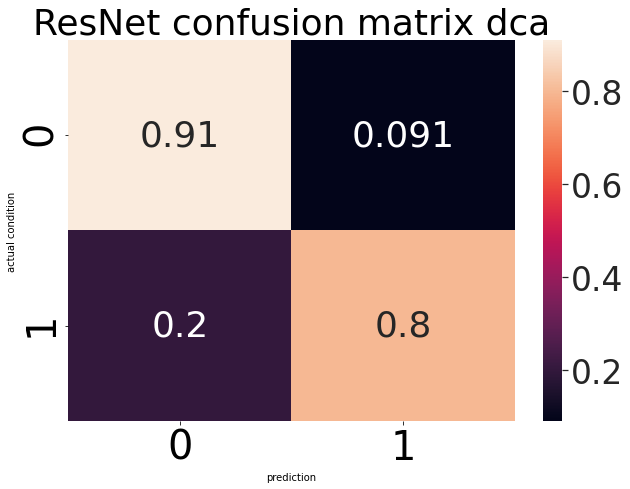

In [9]:
title = "ResNet confusion matrix dca"
cm = sklearn.metrics.confusion_matrix(yt_dca, yp_dca, normalize='true')
df_cm = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sn.set(font_scale=3.0)
sn.heatmap(df_cm, annot=True, ax=ax)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.xaxis.set_ticklabels(["0", "1"])
ax.set_xlabel("prediction")
ax.yaxis.set_ticklabels(["0", "1"])
ax.set_ylabel("actual condition")
plt.title(title)
plt.savefig("resnet_confusion_matrix_dca")

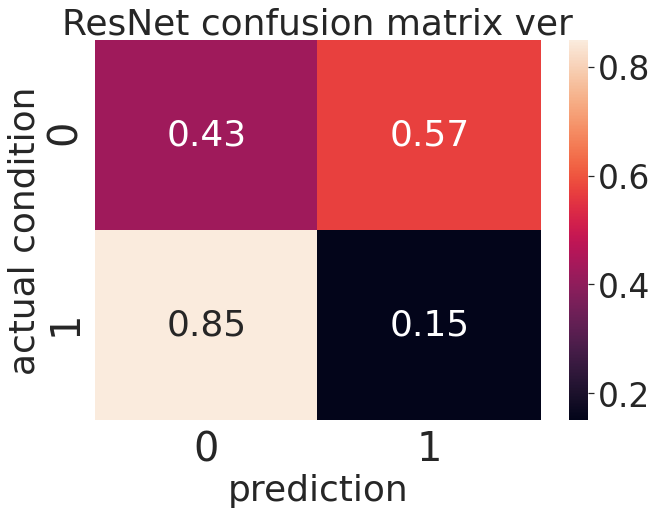

In [10]:
title = "ResNet confusion matrix ver"
cm = sklearn.metrics.confusion_matrix(yt_ver, yp_ver, normalize='true')
df_cm = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
plt.figure(figsize=(10, 7))
ax = plt.subplot()
sn.set(font_scale=3.0)
sn.heatmap(df_cm, annot=True, ax=ax)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.xaxis.set_ticklabels(["0", "1"])
ax.set_xlabel("prediction")
ax.yaxis.set_ticklabels(["0", "1"])
ax.set_ylabel("actual condition")
plt.title(title)
plt.savefig("resnet_confusion_matrix_ver")